# Know where you are?

In [20]:
setwd("/home/ismail/Belgeler")# this will change your directory.
getwd() # where your working directory is set at this moment

[1] "/home/ismail/Belgeler"

In [21]:
setwd("/home/ismail/Belgeler/historicaldatasets")
getwd()

[1] "/home/ismail/Belgeler/historicaldatasets"

# Read Data From EXCEL

In [1]:
library(readxl)
#ilk 3 satırı geçtikten sonra col tiplerini date ve numeric olarak al (text yazabilirdik) ve su şekilde kaydet
veri <- read_excel("USDTRY_Historical_Data.xlsx", skip = 3,
                   col_types = c("date","numeric"), col_names = c("Dates","Lastprice"))
head(veri)
names(veri)
str(veri)
summary(veri)

Dates,Lastprice
1997-10-20,0.1808
1997-10-21,0.1813
1997-10-22,0.1820
1997-10-23,0.1818
1997-10-24,0.1826
1997-10-27,0.1828


[1] "Dates"     "Lastprice"

Classes 'tbl_df', 'tbl' and 'data.frame':	5289 obs. of  2 variables:
 $ Dates    : POSIXct, format: "1997-10-20" "1997-10-21" ...
 $ Lastprice: num  0.181 0.181 0.182 0.182 0.183 ...


     Dates                       Lastprice     
 Min.   :1997-10-20 00:00:00   Min.   :0.1808  
 1st Qu.:2003-02-07 00:00:00   1st Qu.:1.3212  
 Median :2008-05-14 00:00:00   Median :1.5123  
 Mean   :2008-05-12 22:52:28   Mean   :1.7428  
 3rd Qu.:2013-08-15 00:00:00   3rd Qu.:1.9491  
 Max.   :2018-11-20 00:00:00   Max.   :6.8838  

In [7]:
by1 <- format(as.Date(veri$Dates,tryFormat=c("%d.%m.%Y")),"%Y-%V")
verimean <- aggregate(veri$Lastprice, list(by1), mean)
logvar <- aggregate(veri$Lastprice, list(by1), function(x) log(var(x)))

In [6]:
library(forecast)
res1 <- aggregate(veri$Lastprice, list(by1), var)
res2 <- aggregate(veri$Lastprice, list(by1), function(x) log(var(x)))
res1 <- tsclean(res1)
res2 <- tsclean(res2)
class(res2$x)
#hist(res1)
hist(res2)

Warning message in data.matrix(data):
"Zorlamadan dolayı ortaya çıkan NAs"

ERROR: Error in na.interp(x, lambda = lambda): The time series is not univariate.


In [3]:
#verinin Lastprice nı Dateslerinden yıl ve ay ları aynı olanları split etti, make group.
monthlydata <- split(veri$Lastprice, format(veri$Dates, "%Y-%m")) # liste şeklinde save etti.
#class(monthlydata) or str(monthlydata) you can know that which types it has.
#sapply fonksiyonu, veriye şu işlemi yapıyor.Veride ki her listeyi alıp, o listenin uzunluğunu bulup liste[uzunluk]
#dediğimizde listenin son değerine ulaşıyor ve ilk değerine bölüp logarithma alıyor.
#bu işlemi her liste için uyguluyor.
#sapply(monthlydata,mean) # mean bir fonksiyon olduğu için her liste için mean hesaplıyor.
#nonlogreturn <- sapply(monthlydata, function(x){x[length(x)]/x[1]}) # ayın başında para yatırıp, ayın sonunda 
#yüzde kar elde ettiğini söyler. For instance, 2018-08 ayında 1.30 gelen değer.sana %30 para kazandırdığını söyler
logreturn <- sapply(monthlydata, function(x){log(x[length(x)]/x[1])})
#str(logreturn) # veriler numeric olarak kaydedildi

# It's time to bulding "Time_Series"

In [72]:
timeseries <- ts(logreturn, frequency = 12, start = c(1997,10), names = names(logreturn))
#time(timeseries)

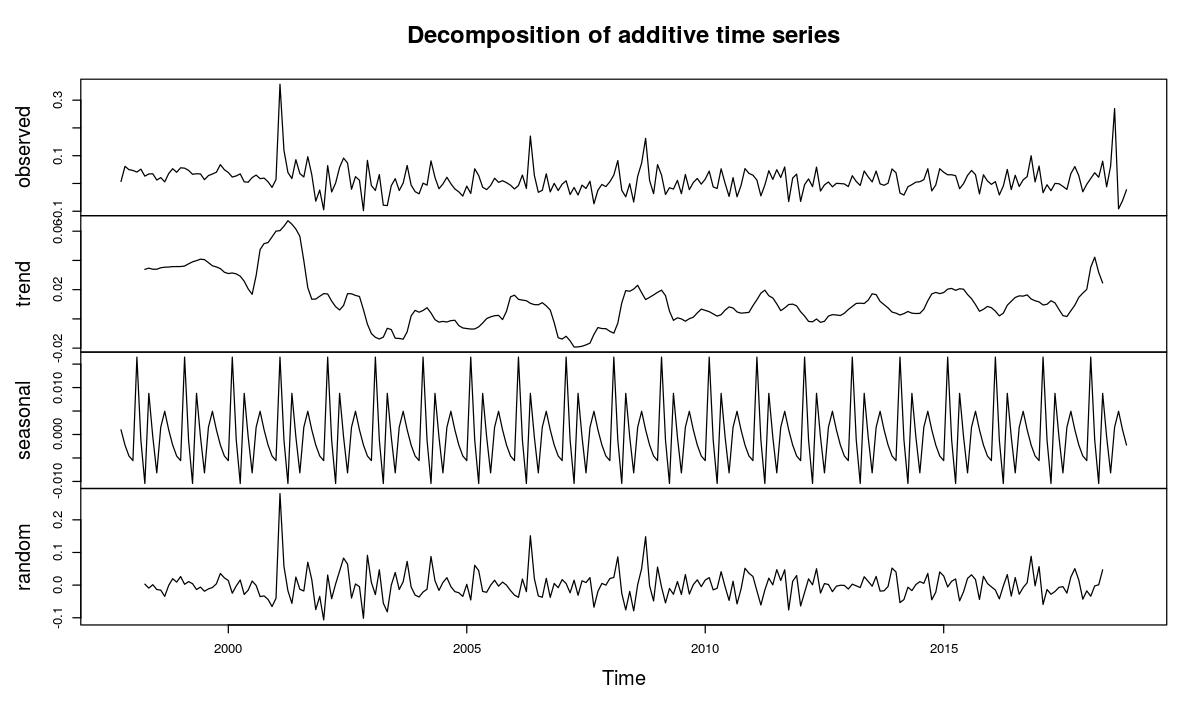

In [132]:
plot(decompose( timeseries ))

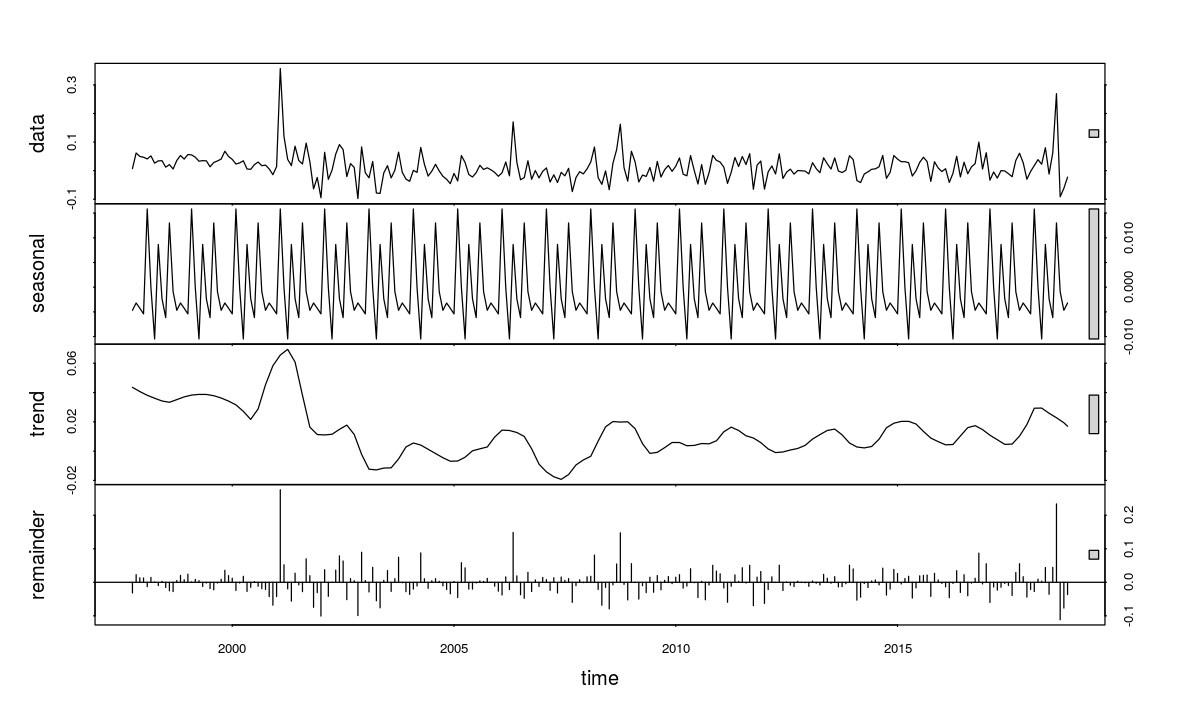

In [135]:
plot(stl( timeseries , s.window = "periodic"))

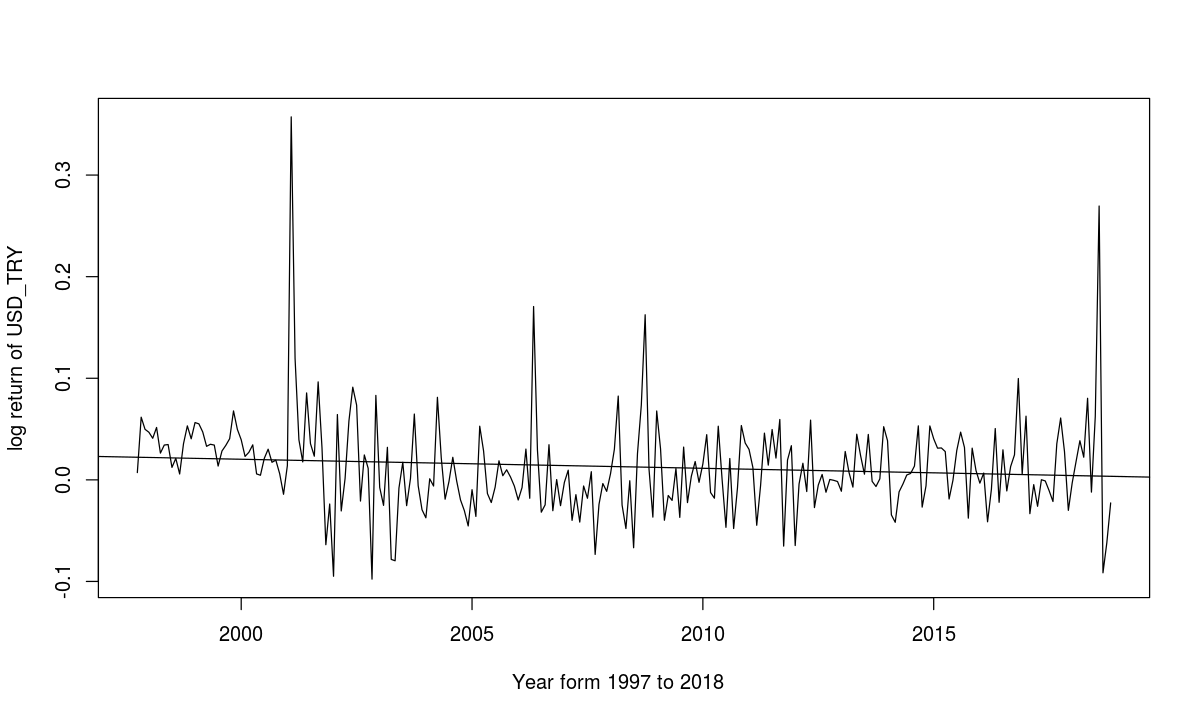

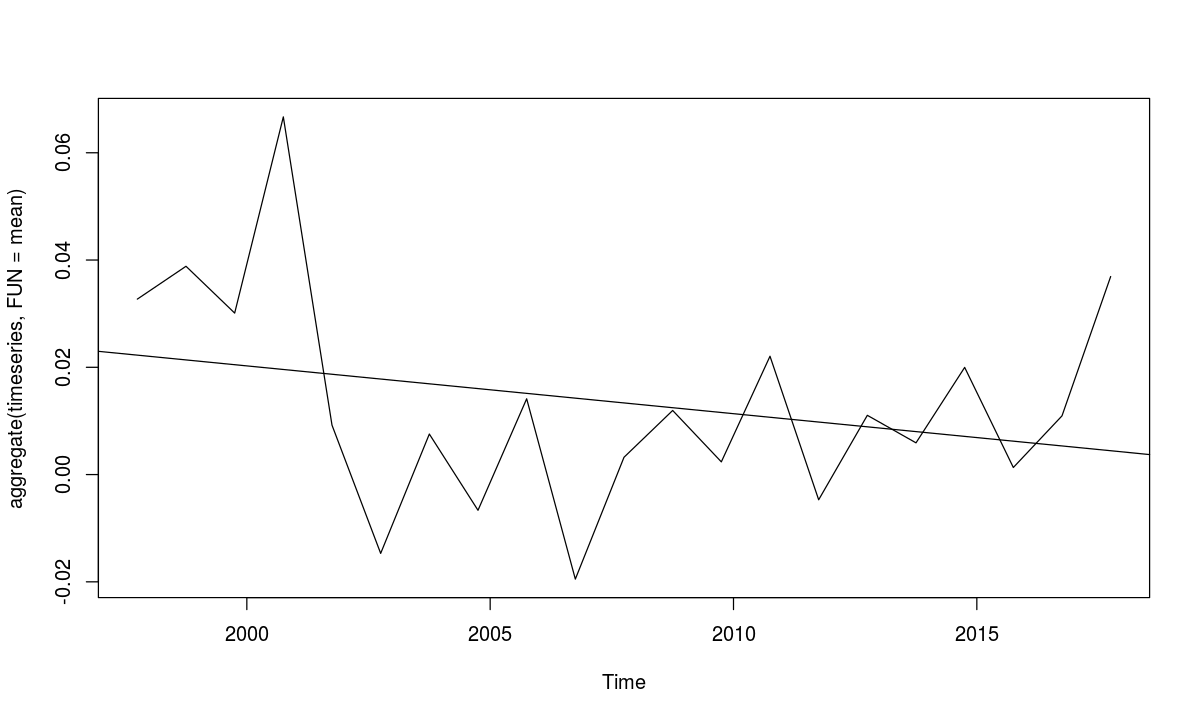

In [75]:
#library("repr")
#Change plot size.
options(repr.plot.width=10, repr.plot.height=6)
plot(timeseries, ylab= "log return of USD_TRY", xlab = "Year form 1997 to 2018  ")
abline(reg=lm( timeseries ~ time(timeseries)))
plot(aggregate( timeseries, FUN = mean)) # This will aggregate the cycles and display a year on year trend
abline(reg = lm( timeseries ~ time(timeseries)))

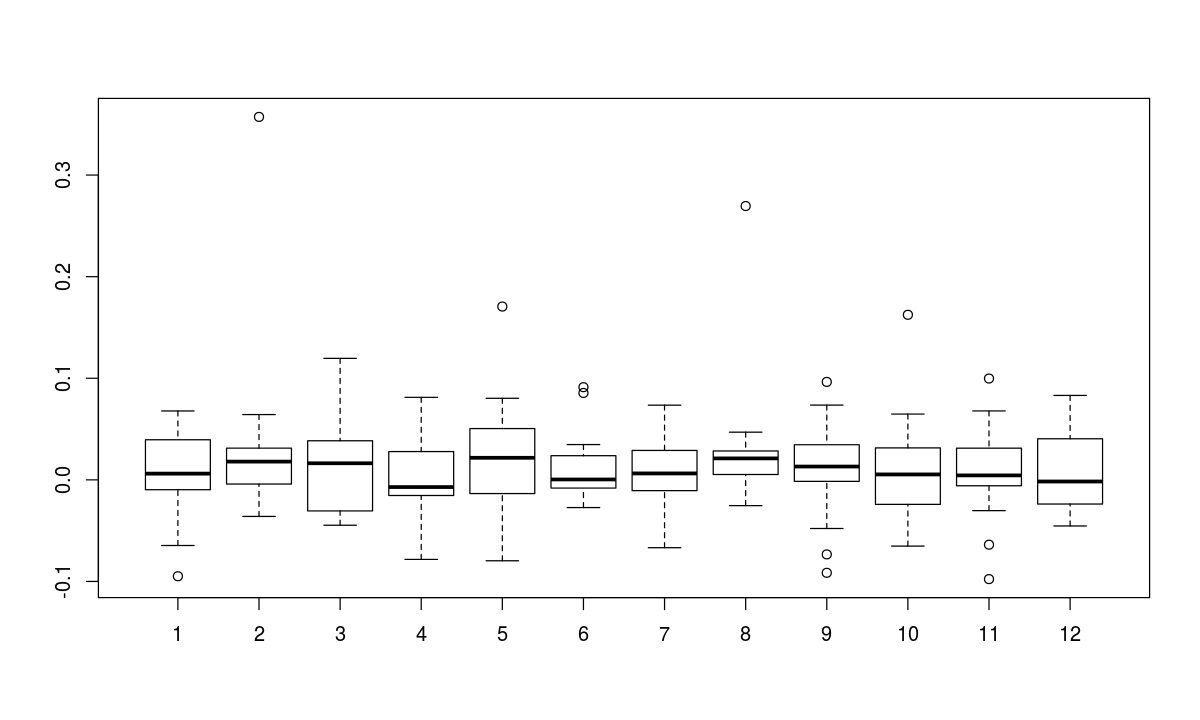

In [76]:
boxplot(timeseries~cycle(timeseries)) # boxplot across months will give us a sense on seasonal effect

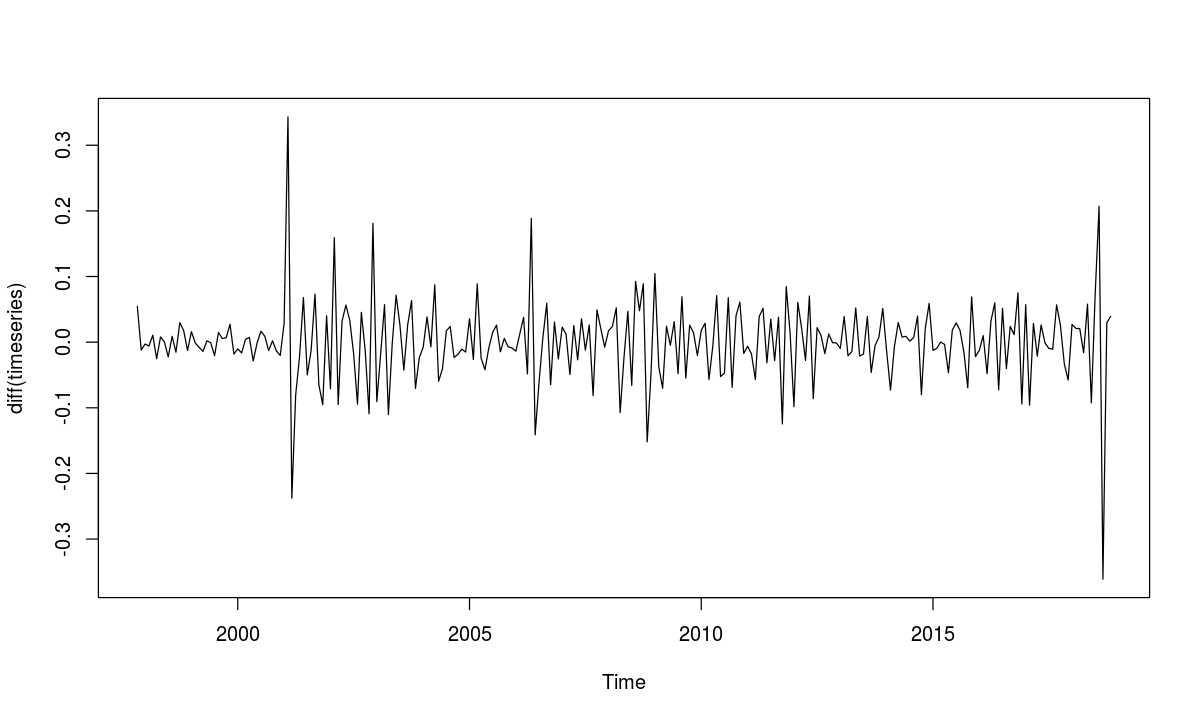

In [81]:
#plot(diff(log( timeseries + 1))) # timeserisinde negatif sayılar vardı onlardan kurtulmak için bir ekledim.
plot(diff(timeseries))

In [130]:
#install.packages("tseries")
library(tseries)
adf.test(diff( timeseries ), alternative = c("stationary", "explosive"), k=0 ) 
#Computes the Augmented Dickey-Fuller test for the null that x has a unit root.

Warning message in adf.test(diff(timeseries), alternative = c("stationary", "explosive"), :
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  diff(timeseries)
Dickey-Fuller = -24.207, Lag order = 0, p-value = 0.01
alternative hypothesis: stationary


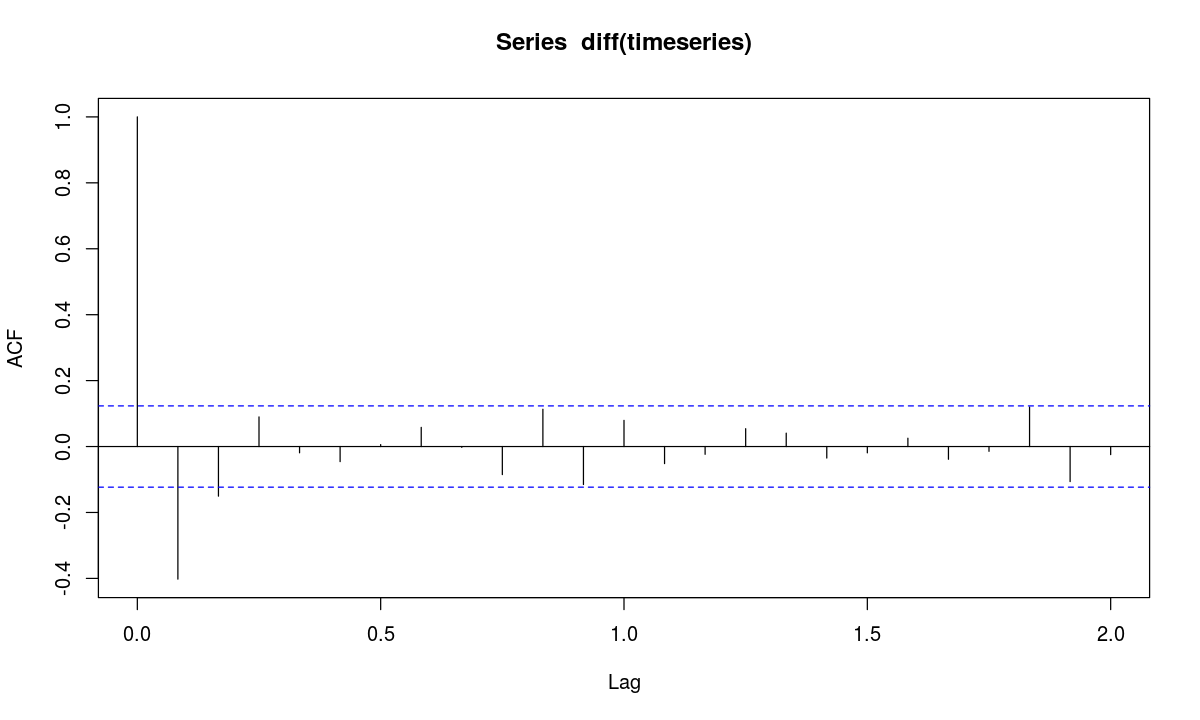

In [84]:
acf(diff( timeseries )) # give to us the value of q for MA(q)
#The first line which is include the region determined by blue dashline gives to us lag-q

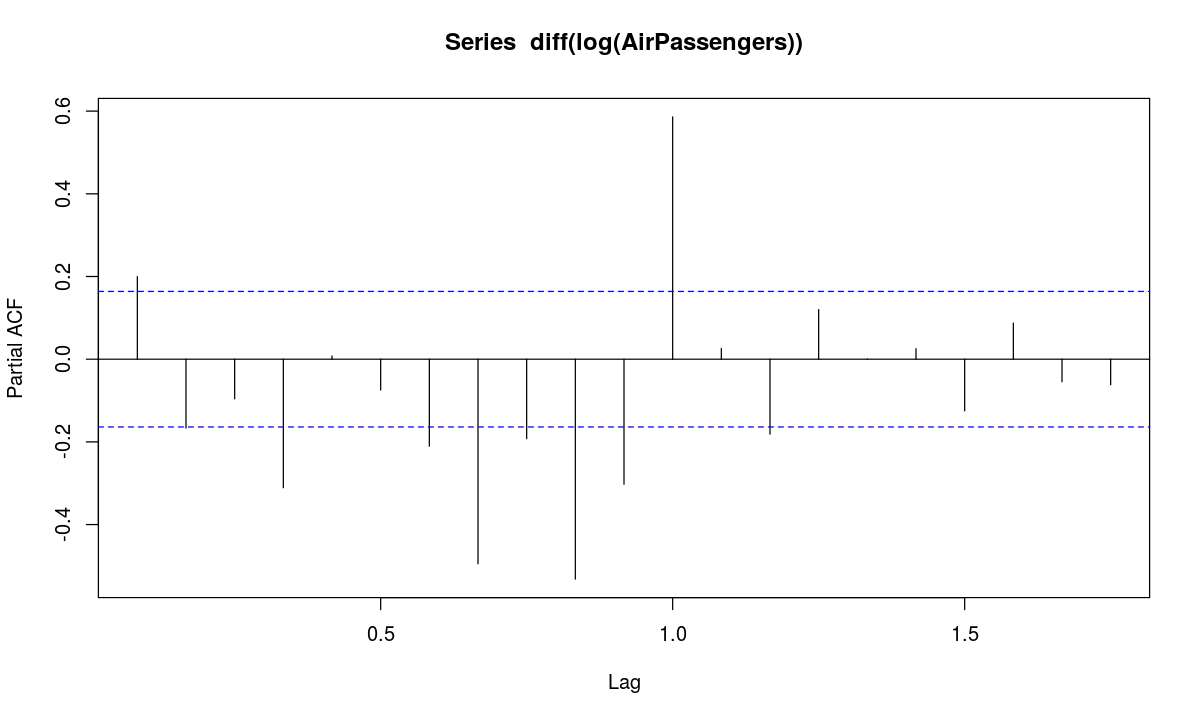

In [85]:
pacf(diff(log(AirPassengers))) # determines the value of p for AR(p)

In [89]:
fit <-arima( timeseries , c(0, 1, 1))
#fit <-arima( timeseries ), c(0, 1, 1), seasonal = list( order = c(0,1,1), period = 12))

In [90]:
pred <- predict(fit, n.ahead = 1*12 ) # This will predicting values for the next  year(12 mounth)
pred1 <- exp(pred$pred) # The result should be convert into   log(x)=y, x = exp(y)
pred1

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2018                                                                        
2019 1.016125 1.016125 1.016125 1.016125 1.016125 1.016125 1.016125 1.016125
          Sep      Oct      Nov      Dec
2018                            1.016125
2019 1.016125 1.016125 1.016125         

In [92]:
fit


Call:
arima(x = timeseries, order = c(0, 1, 1))

Coefficients:
          ma1
      -0.9555
s.e.   0.0186

sigma^2 estimated as 0.002216:  log likelihood = 412.95,  aic = -821.9

# Test Our Model 
## burası olmadı...:(

In [125]:
datatrain <- ts(logreturn, frequency = 12, start = c(1997,10), end = c(2017,12))
fit <- arima(datatrain, c(0,1,1))
pred <- predict(fit, n.ahead = 1*11)

In [126]:
predict_2018 <- pred$pred
original_2018 <- tail(logreturn,11)

In [129]:
original_2018

2018-01     2018-02     2018-03     2018-04     2018-05     2018-06 
-0.00303103  0.01795342  0.03850396  0.02230446  0.08028022 -0.01203295 
    2018-07     2018-08     2018-09     2018-10     2018-11 
 0.06249476  0.26951867 -0.09147637 -0.06195027 -0.02272074

# Maybe, there is an automatically arima in some where, who one know that

In [95]:
library(forecast)
model <- auto.arima( timeseries )
model

Series: timeseries 
ARIMA(1,1,2) 

Coefficients:
          ar1      ma1      ma2
      -0.4275  -0.4068  -0.5331
s.e.   0.2684   0.2468   0.2342

sigma^2 estimated as 0.0022:  log likelihood=415.36
AIC=-822.72   AICc=-822.56   BIC=-808.59

In [96]:
predict(model, 12)

$pred
             Jan         Feb         Mar         Apr         May         Jun
2018                                                                        
2019 0.018603170 0.013687107 0.015788787 0.014890292 0.015274410 0.015110195
             Jul         Aug         Sep         Oct         Nov         Dec
2018                                                             0.007103949
2019 0.015180399 0.015150386 0.015163217 0.015157731 0.015160076            

$se
            Jan        Feb        Mar        Apr        May        Jun
2018                                                                  
2019 0.04754863 0.04755131 0.04764801 0.04767229 0.04772156 0.04775903
            Jul        Aug        Sep        Oct        Nov        Dec
2018                                                        0.04690897
2019 0.04780130 0.04784144 0.04788242 0.04792300 0.04796370           


# Read Data from adjust CSV file

In [66]:
data <- read.csv("USDTRY_Historical_Data.csv", header = TRUE, sep=";", dec = ",")
#head(data)
#names(data)
#str(data)
data$Dates <- as.Date(data$Dates, "%d.%m.%Y")
#str(data)
summary(data)

     Dates              Last_Price    
 Min.   :1997-10-20   Min.   :0.1808  
 1st Qu.:2003-02-07   1st Qu.:1.3212  
 Median :2008-05-14   Median :1.5123  
 Mean   :2008-05-12   Mean   :1.7428  
 3rd Qu.:2013-08-15   3rd Qu.:1.9491  
 Max.   :2018-11-20   Max.   :6.8838  

In [68]:
splitdata <- split(data$Last_Price, format(data$Dates, "%Y-%m"))
#sapply(splitdata, length)
#sapply(splitdata, mean)
#splitdata$'1997-10'
#splitdata$'1997-10'[1]
#splitdata$'1997-10'[length(splitdata$'1997-10')]
#log(1821/1808)
#unlist(splitdata) en son kullan bunu,listeleri birleştirirken.
#splitdata
newtimeserie<-sapply(splitdata , function(x){log(x[length(x)]/x[1])})
#newtimeserie<-lapply(splitdata , function(x){log(x[length(x)]/x[1])})
#summary(newtimeserie)
#names(newtimeserie)
tsnewts <- ts(newtimeserie, frequency = 12, start = c(1997,10), names=names(newtimeserie))
start(tsnewts)
end(tsnewts)
summary(tsnewts)

[1] 1997   10

[1] 2018   11

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.09769 -0.01213  0.00759  0.01287  0.03425  0.35727 

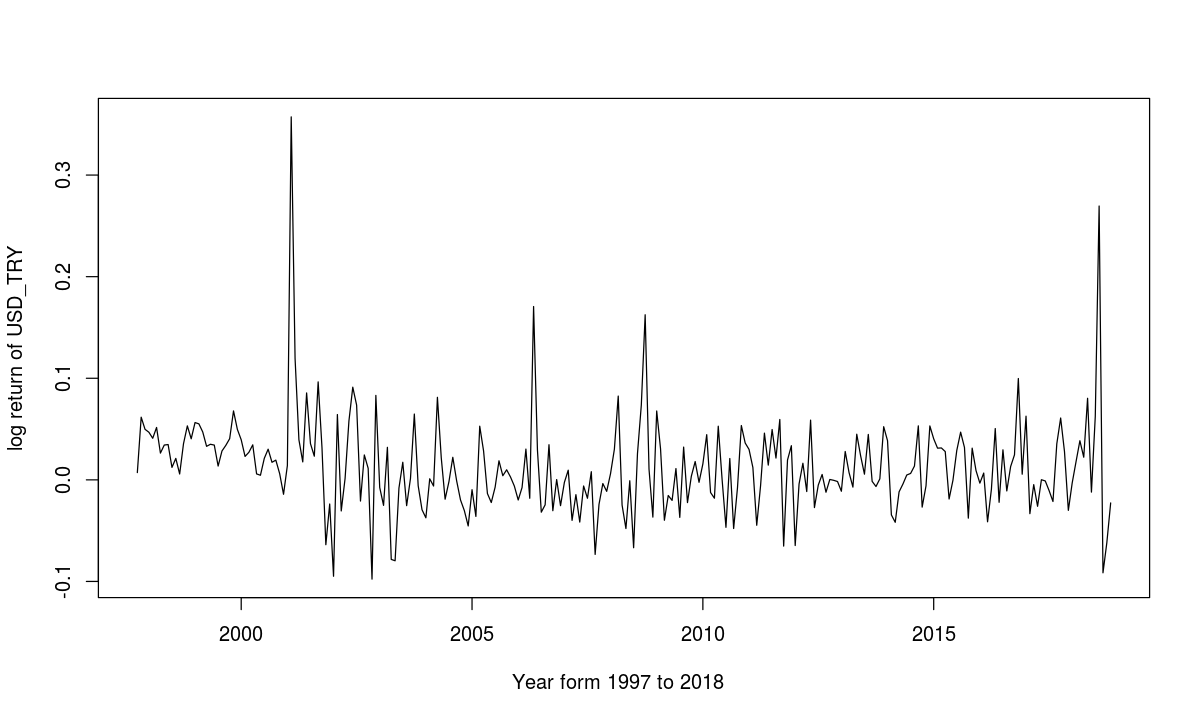

In [30]:
#library("repr")
#Change plot size.
options(repr.plot.width=10, repr.plot.height=6)
plot(tsnewts, ylab= "log return of USD_TRY", xlab = "Year form 1997 to 2018  ")